
### Imports

In [2]:
%pylab inline
import polybin as pb
import healpy
from scipy.interpolate import InterpolatedUnivariateSpline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import importlib
importlib.reload(pb);

### Options

In [4]:
# HEALPix settings
Nside = 128
lmax = 3*Nside-1

# Binning parameters
dl = 20 # width
Nl = 6 # number
min_l = 2 # minimum
print("binned lmax: %d"%(min_l+dl*Nl))

# Number of random iterations to create Fisher matrix
N_it = 100

# Number of simulations to use for testing
N_sim = 1000

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# whether to add a separable reduced bispectrum to the input maps
option=2

if option==1:
    include_mask = False
else:
    include_mask = True

include_synthetic_b = False
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

binned lmax: 122


### Fiducial Power and Noise Spectrum

In [5]:
from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>2)

### Load mask

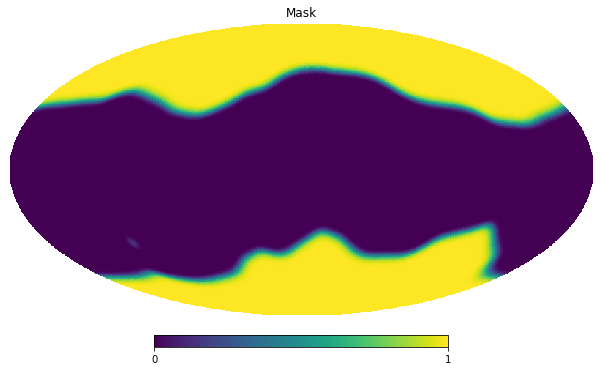

In [6]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
if not include_mask:
    mask = 1.+0.*mask
healpy.mollview(mask,title='Mask')

### Initialize PolyBin class

In [7]:
# Load class with fiducial Cl and Nside
base = pb.PolyBin(Nside, Cl_th+Nl_th+(l<2)*Cl_th[2])

### Generate Synthetic Data with known $C_\ell$

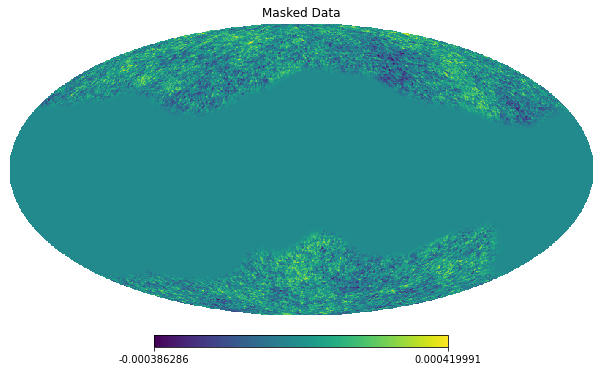

In [8]:
# Generate unmasked data with known C_l and factorized b
# Cl is set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=include_synthetic_b, b_input=b_input_fac)

# Mask the map
data = raw_data*mask

# Plot the data
healpy.mollview(data,title='Masked Data')

### Define weighting function (user-set)
- A simple option would be ```applySinv=base.applyUinv```, which matches the code below.
- The idealized estimators just use a $C_{\rm fid}^{-1}$ weighting (which should include noise).

In [9]:
def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = base.to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = base.to_map(base.safe_divide(input_map_lm,base.Cl_lm))
    
    return Cinv_map

# Trispectrum estimation

In [10]:
importlib.reload(pb)
base = pb.PolyBin(Nside,Cl_th+Nl_th+(l<2)*Cl_th[2])

In [43]:
# Initialize trispectrum class
tspec = pb.TSpec(base, mask, applySinv, min_l, dl, Nl)
tspec._compute_even_symmetry_factor()
tspec._compute_odd_symmetry_factor()

Binning: 6 bins in [2, 122]
Using 455 even-parity trispectrum bins
Using 386 odd-parity trispectrum bins


In [12]:
edge_filt = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                # always include all bins here for counting!
                if bin1==bin3 and bin4<bin2: continue
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not tspec._check_bin(bin1,bin2,binL,even=False): continue
                    if not tspec._check_bin(bin3,bin4,binL,even=False): continue
                    if bin1!=Nl-1 and bin2!=Nl-1 and bin3!=Nl-1 and bin4!=Nl-1 and binL!=Nl-1:
                        edge_filt.append(True)
                    else:
                        edge_filt.append(False)
i_odd = np.sum(edge_filt)
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                # always include all bins here for counting!
                if bin1==bin3 and bin4<bin2: continue
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not tspec._check_bin(bin1,bin2,binL,even=False): continue
                    if not tspec._check_bin(bin3,bin4,binL,even=False): continue
                    if bin1==bin3 and bin4==bin2: continue
                    if bin1!=Nl-1 and bin2!=Nl-1 and bin3!=Nl-1 and bin4!=Nl-1 and binL!=Nl-1:
                        edge_filt.append(True)
                    else:
                        edge_filt.append(False)

In [13]:
weights = []
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                # always include all bins here for counting!
                if bin1==bin3 and bin4<bin2: continue
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not tspec._check_bin(bin1,bin2,binL,even=False): continue
                    if not tspec._check_bin(bin3,bin4,binL,even=False): continue
                    weights.append((min_l+(bin1+0.5)*dl)*(min_l+(bin2+0.5)*dl)*(min_l+(bin3+0.5)*dl)*(min_l+(bin4+0.5)*dl)*1e24)
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                # always include all bins here for counting!
                if bin1==bin3 and bin4<=bin2: continue
                for binL in range(Nl):
                    # skip bins outside the triangle conditions
                    if not tspec._check_bin(bin1,bin2,binL,even=False): continue
                    if not tspec._check_bin(bin3,bin4,binL,even=False): continue
                    weights.append((min_l+(bin1+0.5)*dl)*(min_l+(bin2+0.5)*dl)*(min_l+(bin3+0.5)*dl)*(min_l+(bin4+0.5)*dl)*1e24)
weights = np.asarray(weights)

### Load Fisher matrices

#### note lower lmax here!!

In [14]:
from scipy.linalg import block_diag

fish_ideal = block_diag(*np.load('/projects/QUIJOTE/Oliver/polybin_testing/tfish_ideal_2_20_5.npy',allow_pickle=True))

In [33]:
N_it = 10

In [34]:
### Load external Fisher matrices

fishs = []
fish_ideals = []

for optionF in [1,2]:
    
    fish = 0.
    ct = 0
    for i in range(N_it):
        try:
            fish += np.load('/projects/QUIJOTE/Oliver/polybin_testing/tfish%d_%d.npy'%(optionF,i))
            ct += 1
        except IOError:
            pass
    fish /= ct
    print("Using %d simulations"%ct)
    fishs.append(0.5*(fish+fish.T))
    
    # Initialize bispectrum class
    if option==1:
        this_tspec = pb.TSpec(base, 1.+0.*mask, applySinv, min_l, dl, Nl)
    else:
        this_tspec = pb.TSpec(base, mask, applySinv, min_l, dl, Nl)

Using 10 simulations
Binning: 6 bins in [2, 122]
Using 10 simulations
Binning: 6 bins in [2, 122]


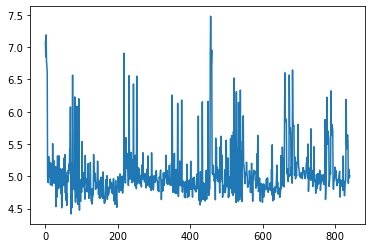

In [35]:
plt.plot(np.diag(fishs[0])/np.diag(fishs[1]))

In [36]:
Tl_opts = []
Tl_opts_no02 = []
Tl_ideals = []

for o,optionF in enumerate([1,2]):

    inv_fish_opt = np.linalg.inv(fishs[o])
    inv_fish_ideal = np.linalg.inv(fish_ideal)

    Tl_opt, Tl_opt_no02, Tl_ideal = [],[],[]
    ct = 0
    for i in range(N_sim):
        try:
            d1 = np.load('/projects/QUIJOTE/Oliver/polybin_testing/tnum%d_opt%d.npy'%(optionF,i),allow_pickle=True)
            d2 = np.load('/projects/QUIJOTE/Oliver/polybin_testing/tnum%d_opt%d_no02.npy'%(optionF,i),allow_pickle=True)
            d3 = np.load('/projects/QUIJOTE/Oliver/polybin_testing/tnum%d_ideal%d.npy'%(optionF,i),allow_pickle=True)
            ct += 1
        except IOError:
            continue
        Tl_opt.append(inv_fish_opt@np.concatenate(d1))
        Tl_opt_no02.append(inv_fish_opt@np.concatenate(d2))
        Tl_ideal.append(inv_fish_ideal@np.concatenate(d3)[edge_filt])
        
    Tl_opts.append(Tl_opt)
    Tl_opts_no02.append(Tl_opt_no02)
    Tl_ideals.append(Tl_ideal)
    print("Using %d simulations"%ct)

Using 1000 simulations
Using 999 simulations


In [37]:
Tl_opts10 = Tl_opts.copy()

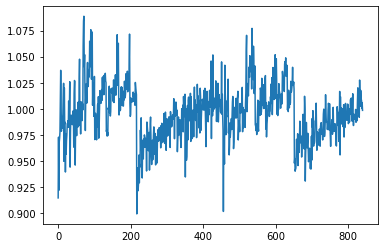

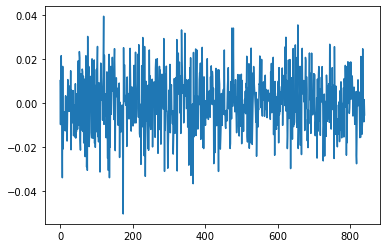

In [39]:
plt.plot(np.asarray(Tl_opts100[1]).std(axis=0)/np.asarray(Tl_opts10[1]).std(axis=0))
plt.figure()
plt.plot((np.asarray(Tl_opts100[1])-np.asarray(Tl_opts10[1])).mean(axis=0)/np.asarray(Tl_opts100[1]).std(axis=0))

### T0 theory

Ideal:\begin{eqnarray}
    \widehat{t}_0(\vec b,L) &\propto& \frac{1}{\Delta_4(\vec b)}\sum_{\ell_1\ell_2m_2}\frac{(2\ell_1+1)(2\ell_2+1)(2L+1)}{4\pi}\begin{pmatrix}\ell_1 & \ell_2 & L\\ -1 & -1 & 2\end{pmatrix}^2\\\nonumber
    &&\,\times\,(-1)^{\ell_1+\ell_2+L}C_{\ell_1}^{-1}C_{\ell_2}^{-1}\left(\delta_{b_1b_3}^{\rm K}\delta_{b_2b_4}^{\rm K}+\delta_{b_1b_4}^{\rm K}\delta_{b_2b_3}^{\rm K}\right).
\end{eqnarray}

In [18]:
t0_num_analyt = []
ii = 0
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                if bin1==bin3 and bin4<bin2: continue
                for binL in range(Nl):
                    if not tspec._check_bin(bin1,bin2,binL): continue
                    if not tspec._check_bin(bin3,bin4,binL): continue

                    kroneckers = (bin1==bin3)*(bin2==bin4)+(bin1==bin4)*(bin2==bin3)
                    if kroneckers==0: 
                        ii += 1
                        t0_num_analyt.append(0.)
                        continue
                        
                    value = 0.
                        
                    # Sum over ells for zero-point terms
                    for l1 in range(min_l+bin1*dl,min_l+(bin1+1)*dl):
                        for l2 in range(min_l+bin2*dl,min_l+(bin2+1)*dl):
                            for L in range(min_l+binL*dl,min_l+(binL+1)*dl):
                                if L<abs(l1-l2) or L>l1+l2: continue
                                pref = (2*l1+1.)*(2*l2+1.)*(2*L+1.)/(4*np.pi)*tspec.threej(l1,l2,L)**2*(-1.)**(l1+l2+L)
                                value += pref/tspec.base.Cl[l1]/tspec.base.Cl[l2]*kroneckers
                    t0_num_analyt.append(value/tspec.sym_factor_even[ii])
                    ii += 1
for _ in range(tspec.N_t_odd):
    t0_num_analyt.append(0.)

## Plot with disconnected pieces

In [19]:
tspec.generate_sims(10)

Using 10 pairs of Monte Carlo simulations


In [20]:
tspec._compute_t0_numerator(parity='both')

### Define terms that should contain disconnected pieces (if ideal)

In [21]:
disc_filt = []
# Even
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                if bin1==bin3 and bin4<bin2: continue
                for binL in range(Nl):
                    if not tspec._check_bin(bin1,bin2,binL): continue
                    if not tspec._check_bin(bin3,bin4,binL): continue
                    if ((bin1==bin3)*(bin2==bin4)+(bin1==bin4)*(bin2==bin3))!=0:
                        disc_filt.append(True)
                    else:
                        disc_filt.append(False)
# Odd (no contributions)
for bin1 in range(Nl):
    for bin2 in range(bin1,Nl):
        for bin3 in range(bin1,Nl):
            for bin4 in range(bin3,Nl):
                if bin1==bin3 and bin4<=bin2: continue
                for binL in range(Nl):
                    if not tspec._check_bin(bin1,bin2,binL): continue
                    if not tspec._check_bin(bin3,bin4,binL): continue
                    disc_filt.append(False)

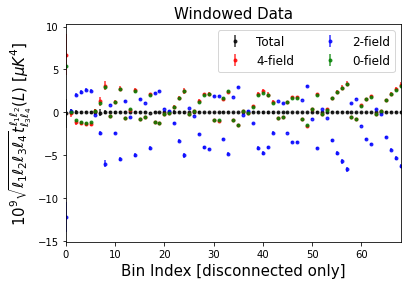

In [22]:
i = option-1
i_arr = np.arange(np.sum(disc_filt))

dweights = np.sqrt(weights)*1e9

# Measured values
t_all = np.asarray(Tl_opts[i]).mean(axis=0)
t4 = np.asarray(Tl_opts_no02[i]).mean(axis=0)
t0 = np.linalg.inv(fishs[i])@np.concatenate([tspec.t0_even_num/tspec.sym_factor_even,tspec.t0_odd_num/tspec.sym_factor_odd])
t2 = t_all-t4-t0
t0_analyt = np.linalg.inv(fishs[0])@t0_num_analyt
t2_analyt = -2*np.linalg.inv(fishs[0])@t0_num_analyt
t4_analyt = np.linalg.inv(fishs[0])@t0_num_analyt
t_analyt = 0.*np.asarray(t0_num_analyt)

# Errors
st_all = np.asarray(Tl_opts[i]).std(axis=0)
st4 = np.asarray(Tl_opts_no02[i]).std(axis=0)
st0 = 0.*t0
st2 = (np.asarray(Tl_opts[i])-np.asarray(Tl_opts_no02[i])-t0).std(axis=0)

# Plot data
plt.errorbar(i_arr,(dweights*t_all)[disc_filt],(dweights*st_all)[disc_filt],
             marker='.',ls='',label='Total',c='k',alpha=0.8)
plt.errorbar(i_arr,(dweights*t4)[disc_filt],(dweights*st4)[disc_filt],
             marker='.',ls='',label='4-field',c='r',alpha=0.8)
plt.errorbar(i_arr,(dweights*t2)[disc_filt],(dweights*st2)[disc_filt],
             marker='.',ls='',label='2-field',c='b',alpha=0.8)
plt.errorbar(i_arr,(dweights*t0)[disc_filt],(dweights*st0)[disc_filt],
             marker='.',ls='',label='0-field',c='g',alpha=0.8)

# Plot errors
if option==1:
    plt.plot(i_arr,(dweights*t4_analyt)[disc_filt],c='r',ls='-',alpha=0.5)
    plt.plot(i_arr,(dweights*t2_analyt)[disc_filt],c='b',ls='-',alpha=0.5)
    plt.plot(i_arr,(dweights*t0_analyt)[disc_filt],c='g',ls='-',alpha=0.5)
    plt.plot(i_arr,(dweights*t_analyt)[disc_filt],c='k',ls='-',alpha=0.5)
plt.xlim(0,len(i_arr)-1)
#plt.yscale('log')
if option==1:
    plt.title("Unwindowed Data",fontsize=15)
else:
    plt.title("Windowed Data",fontsize=15)
plt.legend(fontsize=12,ncol=2)
plt.xlabel(r'Bin Index [disconnected only]',fontsize=15)
plt.ylabel(r'$10^9\sqrt{\ell_1\ell_2\ell_3\ell_4}t^{\ell_1\ell_2}_{\ell_3\ell_4}(L)$ $[\mu K^4]$',fontsize=15);
plt.savefig('testing/Tl_disc%d.pdf'%option,bbox_inches='tight')

### NB: we're really just testing the numerator here, *not* the normalization - this is why this only works for the unwindowed data (the normalization isn't supposed to get the disconnected term correct!)
### Thus we don't plot the prediction if unwindowed!

## Plot Estimates

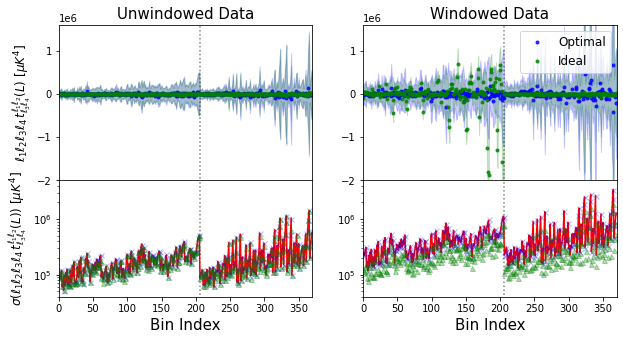

In [23]:
i_arr = np.arange(np.sum(edge_filt))

fig, ax = plt.subplots(2,2,figsize=(10,5),sharex=True,sharey=False,gridspec_kw={'height_ratios': [2,1.5]})
    
for i in [0,1]:
    fig.subplots_adjust(hspace=0)

    inv_fish_opt = np.linalg.inv(fishs[i])
    inv_fish_ideal = np.linalg.inv(fish_ideal)#[i])
    
    fish_err = np.sqrt(np.diag(inv_fish_opt))
    if i==0:
        fish_err_ideal = np.sqrt(np.diag(inv_fish_ideal))
    else:
        fish_err_ideal = np.sqrt(np.diag(inv_fish_ideal))*np.sqrt(np.mean(mask**8)/np.mean(mask**4)**2)    
    
    # Spectra
    ax[0,i].plot(i_arr,(weights*np.asarray(Tl_opts[i]).mean(axis=0))[edge_filt],marker='.',ls='',
                   label='Optimal',c='b',alpha=0.8)
    ax[0,i].fill_between(i_arr,(weights*np.asarray(Tl_opts[i]).mean(axis=0))[edge_filt]-(weights*fish_err)[edge_filt],
                         (weights*np.asarray(Tl_opts[i]).mean(axis=0))[edge_filt]+(weights*fish_err)[edge_filt],
                         color='b',alpha=0.2)
    
    ax[0,i].plot(i_arr,(weights[edge_filt]*np.asarray(Tl_ideals[i]).mean(axis=0)),marker='.',ls='',
                  label='Ideal',c='g',alpha=0.8)
    ax[0,i].fill_between(i_arr,
                         (weights[edge_filt]*np.asarray(Tl_ideals[i]).mean(axis=0))-(weights[edge_filt]*fish_err_ideal),
                         (weights[edge_filt]*np.asarray(Tl_ideals[i]).mean(axis=0))+(weights[edge_filt]*fish_err_ideal),
                         color='g',alpha=0.2)

    # Errors
    ax[1,i].plot(i_arr,(weights*fish_err)[edge_filt],label='Expected error (unwindowed)',c='r',ls='-')
    ax[1,i].plot(i_arr,(weights*np.asarray(Tl_opts[i]).std(axis=0))[edge_filt],label='Unwindowed Error',
               c='b',marker='x',ls='',alpha=0.3,ms=5)
    ax[1,i].plot(i_arr,(weights[edge_filt]*np.asarray(Tl_ideals[i]).std(axis=0)),label='Idealized Error',
               c='g',marker='^',ls='',alpha=0.3,ms=5)

    if i==0:
        ax[0,i].set_title('Unwindowed Data',fontsize=15)
    else:
        ax[0,i].set_title('Windowed Data',fontsize=15)
    ax[1,i].set_xlabel(r'Bin Index',fontsize=15)

    if i==0:
        ax[0,i].set_ylabel(r'$\ell_1\ell_2\ell_3\ell_4\,t^{\ell_1\ell_2}_{\ell_3\ell_4}(L)\,\,[\mu K^4]$',fontsize=12)
        ax[1,i].set_ylabel(r'$\sigma(\ell_1\ell_2\ell_3\ell_4\,t^{\ell_1\ell_2}_{\ell_3\ell_4}(L))\,\,[\mu K^4]$',fontsize=12);
    if i==1:
        ax[0,i].legend(fontsize=12)
    ax[0,i].vlines(i_odd,-1e8,1e8,ls=':',color='k',alpha=0.5)
    ax[1,i].vlines(i_odd,-1e8,1e8,ls=':',color='k',alpha=0.5)
    ax[0,i].set_ylim([-2e6,1.6e6])
    ax[1,i].set_ylim([40000,5000000])
    ax[1,i].set_yscale('log')
    ax[0,i].set_xlim([0,np.sum(edge_filt)])
fig.savefig('testing/Tl_plot.pdf',bbox_inches='tight')

### Note the large differences in windowed data!

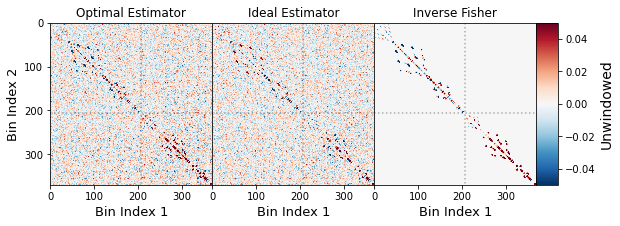

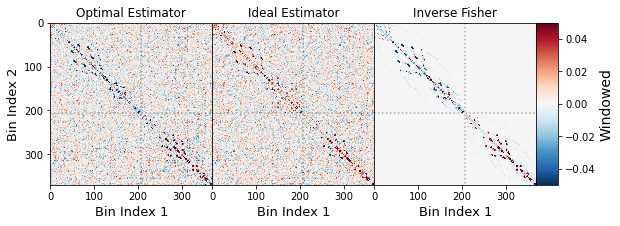

In [24]:
for o in range(2):

    inv_fish_ideal = np.linalg.inv(fish_ideal)
    inv_fish_opt = np.linalg.inv(fishs[o])[edge_filt][:,edge_filt]

    #fish_chol = np.linalg.cholesky(fishs[o]).T
    #cov_unwindowed = np.cov((fish_chol@np.asarray(Tl_opts[o]).T)[edge_filt])

    # Plot correlation matrices
    cov_ideal = np.cov(np.asarray(Tl_ideals[o]).T)
    corr_ideal = cov_ideal/np.sqrt(np.outer(np.diag(cov_ideal),np.diag(cov_ideal)))
    cov_unwindowed = np.cov(np.asarray(Tl_opts[o])[:,edge_filt].T)
    corr_unwindowed = cov_unwindowed/np.sqrt(np.outer(np.diag(cov_unwindowed),np.diag(cov_unwindowed)))
    cov_theory = inv_fish_opt
    corr_theory = cov_theory/np.sqrt(np.outer(np.diag(cov_theory),np.diag(cov_theory)))

    fig,ax = plt.subplots(1,3,figsize=(10,30))
    fig.subplots_adjust(wspace=0)
    v = 0.05
    im=ax[0].imshow(corr_unwindowed-np.eye(len(corr_unwindowed)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
    im=ax[1].imshow(corr_ideal-np.eye(len(corr_ideal)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
    im = ax[2].imshow(corr_theory-np.eye(len(corr_theory)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
    ax[0].set_title("Optimal Estimator")
    ax[1].set_title("Ideal Estimator")
    ax[2].set_title("Inverse Fisher")
    for i in range(3):
        ax[i].set_xticks([0,100,200,300])
        ax[i].set_xticklabels([0,100,200,300])
        ax[i].set_xlabel(r'Bin Index 1',fontsize=13)

        ax[i].hlines(i_odd,0,len(cov_theory),ls=':',color='k',alpha=0.3)
        ax[i].vlines(i_odd,0,len(cov_theory),ls=':',color='k',alpha=0.3)
        ax[i].set_xlim([0,len(cov_theory)])
        ax[i].set_ylim([len(cov_theory),0])

    ax[0].set_yticks([0,100,200,300])
    ax[0].set_yticklabels([0,100,200,300])
    ax[0].set_ylabel(r'Bin Index 2',fontsize=13)
    for i in range(1,3):
        ax[i].set_yticks([])
        ax[i].set_yticklabels([])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.80, 0.465, 0.03, 0.075])
    cbar=fig.colorbar(im, cax=cbar_ax)
    if o==0:
        cbar.set_label('Unwindowed',fontsize=14)
    elif o==1:
        cbar.set_label('Windowed',fontsize=14)
    fig.savefig('testing/Tl_cov%d.pdf'%o,bbox_inches='tight')

### plot $F^{1/2}d$

0.9819565568853567 0.04390103800206635
5.825410321437844 1.3892092703885672


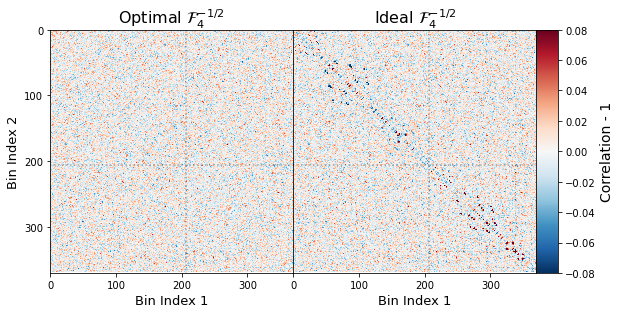

In [31]:
for o in [1]:

    inv_fish_ideal = np.linalg.inv(fish_ideal)
    inv_fish_opt = np.linalg.inv(fishs[o])[edge_filt][:,edge_filt]

    fish_chol = np.linalg.cholesky(fishs[o]).T
    fish_ideal_chol = np.linalg.cholesky(fish_ideal).T
    cov_unwindowed = np.cov((fish_chol@np.asarray(Tl_opts[o]).T)[edge_filt])
    cov_ideal = np.cov((fish_ideal_chol@np.asarray(Tl_opts[o]).T[edge_filt]))

    # Plot correlation matrices
    #cov_ideal = np.cov(np.asarray(Tl_ideals[o]).T)
    corr_ideal = cov_ideal/np.sqrt(np.outer(np.diag(cov_ideal),np.diag(cov_ideal)))
    #cov_unwindowed = np.cov(np.asarray(Tl_opts[o])[:,edge_filt].T)
    corr_unwindowed = cov_unwindowed/np.sqrt(np.outer(np.diag(cov_unwindowed),np.diag(cov_unwindowed)))
    cov_theory = inv_fish_opt
    corr_theory = cov_theory/np.sqrt(np.outer(np.diag(cov_theory),np.diag(cov_theory)))
    print(np.diag(cov_unwindowed).mean(),np.diag(cov_unwindowed).std())
    print(np.diag(cov_ideal).mean(),np.diag(cov_ideal).std())
    
    fig,ax = plt.subplots(1,2,figsize=(10,20))
    fig.subplots_adjust(wspace=0)
    v = 0.08
    im=ax[0].imshow(corr_unwindowed-np.eye(len(corr_unwindowed)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
    im=ax[1].imshow(corr_ideal-np.eye(len(corr_ideal)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
    ax[0].set_title(r"Optimal $\mathcal{F}_4^{-1/2}$",fontsize=16)
    ax[1].set_title(r"Ideal $\mathcal{F}_4^{-1/2}$",fontsize=16)
    for i in range(2):
        ax[i].set_xticks([0,100,200,300])
        ax[i].set_xticklabels([0,100,200,300])
        ax[i].set_xlabel(r'Bin Index 1',fontsize=13)

        ax[i].hlines(i_odd,0,len(cov_theory),ls=':',color='k',alpha=0.3)
        ax[i].vlines(i_odd,0,len(cov_theory),ls=':',color='k',alpha=0.3)
        ax[i].set_xlim([0,len(cov_theory)])
        ax[i].set_ylim([len(cov_theory),0])

    ax[0].set_yticks([0,100,200,300])
    ax[0].set_yticklabels([0,100,200,300])
    ax[0].set_ylabel(r'Bin Index 2',fontsize=13)
    for i in range(1,2):
        ax[i].set_yticks([])
        ax[i].set_yticklabels([])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.80, 0.418, 0.03, 0.169])
    cbar=fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(r'Correlation - 1',fontsize=14)
    fig.savefig('testing/Tl_Fhalf_cov.pdf',bbox_inches='tight')

# OLD

### Window-free estimator

In [13]:
# Generate MC simulations for estimator numerator
bspec.generate_sims(N_it,b_input=b_input_fac,add_B=True,remove_mean=True)

# # Alternatively, read-in MC simulations created externally
# alpha_sims = []
# for ii in range(N_it):
#     alpha = base.generate_data(seed=10000+ii,add_B=include_synthetic_b, b_input=b_input_fac)
#     alpha_sims.append(alpha)
# bspec.load_sims(alpha_sims, verb=True)

Using 20 Monte Carlo simulations
Computing offset for synthetic maps


In [14]:
fish = bspec.compute_fisher(N_it, N_cpus=4)

Computing Fisher contribution from 20 pairs of Monte Carlo simulations on 4 threads


100%|██████████| 20/20 [19:55<00:00, 59.76s/it]  


In [15]:
b_unwindowed = bspec.Bl_unwindowed(data, verb=True, include_linear_term=True)

Computing b_3 piece
Computing b_1 piece from simulation 5
Computing b_1 piece from simulation 10
Computing b_1 piece from simulation 15
Computing b_1 piece from simulation 20


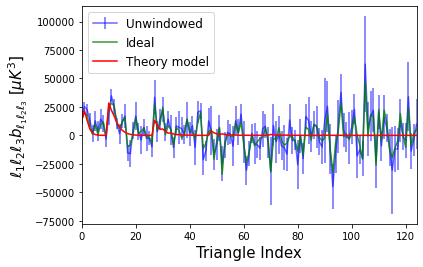

In [16]:
fish_err = np.sqrt(np.diag(np.linalg.inv(bspec.fish)))
plt.errorbar(np.arange(bspec.N_b),weights*b_unwindowed,yerr=weights*fish_err,label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(np.arange(bspec.N_b),weights*b_ideal,label='Ideal',c='g',alpha=0.8)
if include_synthetic_b:
    plt.errorbar(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
else:
    plt.errorbar(np.arange(bspec.N_b),0.*weights*bl_model,label='Theory model',c='r')
plt.legend(fontsize=12)
plt.xlim([0,bspec.N_b-1])
plt.xlabel("Triangle Index",fontsize=15)
plt.ylabel(r"$\ell_1\ell_2\ell_3 b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$",fontsize=15);

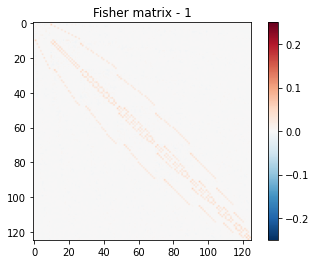

In [17]:
corr_fish_b = bspec.fish/np.sqrt(np.outer(np.diag(bspec.fish),np.diag(bspec.fish)))
v = 0.25
plt.imshow(corr_fish_b-np.eye(len(corr_fish_b)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Fisher matrix - 1")
plt.colorbar();

### Iterate over multiple datasets

In [18]:
b_unwindowed_all = []
b_ideal_all = []

for jj in range(N_sim):
    
    if jj%10==0: 
        print("Analyzing simulation %d of %d"%(jj+1,N_sim))

    # Generate unmasked data
    data = mask*base.generate_data(jj,add_B=include_synthetic_b, b_input=b_input_fac)

    b_ideal_all.append(bspec.Bl_ideal(data))
    b_unwindowed_all.append(bspec.Bl_unwindowed(data,verb=False))

Analyzing simulation 1 of 50
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Analyzing simulation 11 of 50
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Analyzing simulation 21 of 50
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomput

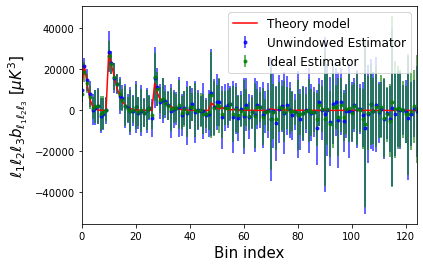

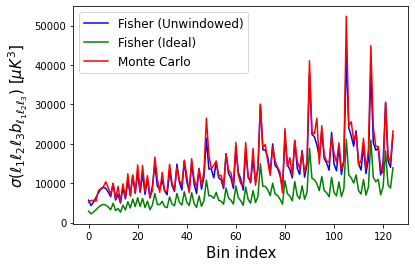

In [19]:
fish_err = np.sqrt(np.diag(bspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(bspec.inv_fish_ideal))

plt.errorbar(np.arange(bspec.N_b),weights*np.asarray(b_unwindowed_all).mean(axis=0),yerr=weights*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b',alpha=0.8)
plt.plot(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
plt.errorbar(np.arange(bspec.N_b),weights*np.asarray(b_ideal_all).mean(axis=0),yerr=weights*np.asarray(b_ideal_all).std(axis=0),
             ls='',marker='.',label='Ideal Estimator',alpha=0.8,c='g')
plt.xlim([0,bspec.N_b-1])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

plt.figure()
plt.plot(np.arange(bspec.N_b),weights*fish_err,label='Fisher (Unwindowed)',c='b')
plt.plot(np.arange(bspec.N_b),weights*fish_err_ideal,label=r'Fisher (Ideal)',c='g')
plt.plot(np.arange(bspec.N_b),weights*np.asarray(b_unwindowed_all).std(axis=0),label='Monte Carlo',c='r')
plt.xlabel(r'Bin index',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3})\,\,[\mu K^3]$',fontsize=15);

# Trispectrum Estimation

We now consider the trispectrum. Since trispectrum estimation is considerably more expensive, we'll use a broader binning here. In general, calculations would be performed on a cluster, but we'll pick a small problem below for testing on a single computer.

In [1]:
%pylab inline
import healpy
import polybin as pb
from scipy.interpolate import InterpolatedUnivariateSpline

# HEALPix settings
Nside = 128
lmax = 3*Nside-1

# Binning parameters
dl = 30 # width
Nl = 10 # number
min_l = 2 # minimum
print("binned lmax: %d"%(min_l+dl*Nl))

# Number of random iterations to create Fisher matrix
N_it = 20

# Number of simulations to use for testing
N_sim = 50

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# whether to add a separable reduced bispectrum to the input maps
include_synthetic_b = True
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>2)

mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)

# print("REMOVING MASK")
# mask = np.ones_like(mask)

# Load class
base = pb.PolyBin(Nside,Cl_th+Nl_th)

# Generate unmasked data with known C_l and factorized b
# Cl is set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=include_synthetic_b, b_input=b_input_fac)

# Mask the map
data = raw_data*mask

def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = base.to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = base.to_map(base.safe_divide(input_map_lm,base.Cl_lm))
    
    return Cinv_map

Populating the interactive namespace from numpy and matplotlib
binned lmax: 302
Computing offset for synthetic maps


In [2]:
# Initialize trispectrum class
min_l = 10
dl = 20
Nl = 4
tspec = pb.TSpec(base, mask, applySinv, min_l, dl, Nl)

Binning: 4 bins in [10, 90]


In [3]:
fish_odd = tspec.compute_fisher(1,parity='odd',N_cpus=1,verb=True)

Using 121 odd-parity trispectrum bins
Computing Fisher contribution 1 of 1

Generating data

Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields

Computing Fisher matrix contribution
On bin 1 of 121
On bin 6 of 121
On bin 11 of 121
On bin 16 of 121
On bin 21 of 121
On bin 26 of 121
On bin 31 of 121
On bin 36 of 121
On bin 41 of 121
On bin 46 of 121
On bin 51 of 121
On bin 56 of 121
On bin 61 of 121
On bin 66 of 121
On bin 71 of 121
On bin 76 of 121
On bin 81 of 121
On bin 86 of 121
On bin 91 of 121
On bin 96 of 121
On bin 101 of 121
On bin 106 of 121
On bin 111 of 121
On bin 116 of 121
On bin 121 of 121


In [4]:
tspec.generate_sims(10)

Using 10 Monte Carlo simulations


In [5]:
t_odd = tspec.Tl_unwindowed(data,parity='odd',verb=True)

Computing t0 term
Computing H^+- maps
Computing A maps
Computing A maps for cross-spectra
Assembling parity-odd trispectrum numerator


In [6]:
fish_both = tspec.compute_fisher(1,parity='both',N_cpus=1,verb=True)

Using 154 even-parity trispectrum bins
Computing Fisher contribution 1 of 1

Generating data

Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields

Computing Fisher matrix contribution
On bin 1 of 154
On bin 6 of 154
On bin 11 of 154
On bin 16 of 154
On bin 21 of 154
On bin 26 of 154
On bin 31 of 154
On bin 36 of 154
On bin 41 of 154
On bin 46 of 154
On bin 51 of 154
On bin 56 of 154
On bin 61 of 154
On bin 66 of 154
On bin 71 of 154
On bin 76 of 154
On bin 81 of 154
On bin 86 of 154
On bin 91 of 154
On bin 96 of 154
On bin 101 of 154
On bin 106 of 154
On bin 111 of 154
On bin 116 of 154
On bin 121 of 154
On bin 126 of 154
On bin 131 of 154

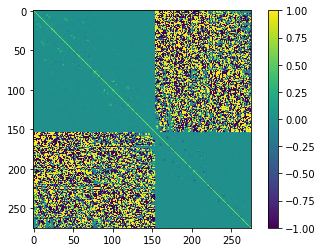

In [10]:
ff = fish_both
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

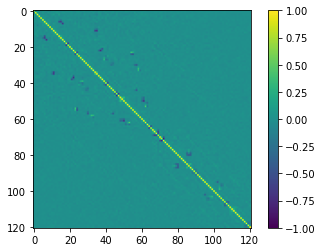

In [7]:
ff = fish_odd
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

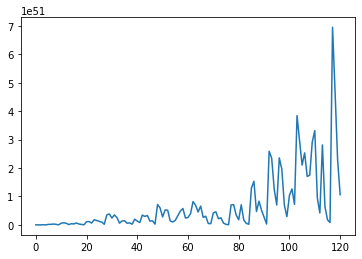

In [8]:
plt.plot(np.diag(fish_odd))

<ErrorbarContainer object of 3 artists>

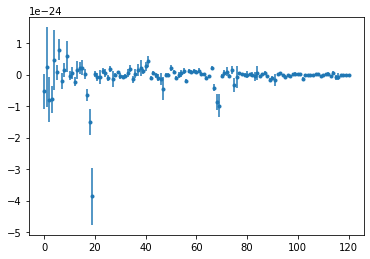

In [9]:
plt.errorbar(np.arange(tspec.N_t_odd),t_odd,yerr=np.sqrt(np.diag(tspec.inv_fish_odd)),ls='',marker='.')

### no mask here!

### a) window is weird??

### b) off-diagonal is weird - should asymptote to zero?

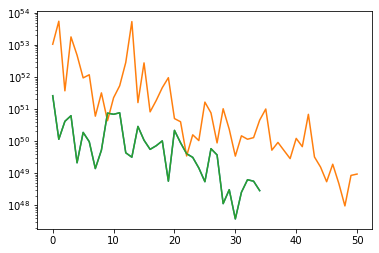

In [20]:
plt.plot(np.abs(np.diag(fish_both)[tspec.N_t_even:]))
plt.plot(np.diag(fish_even))
plt.plot(-np.diag(fish_odd))
plt.yscale('log')

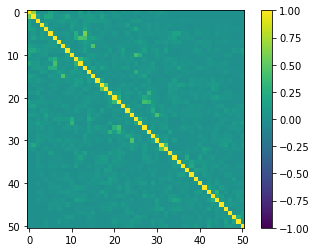

In [40]:
ff = np.abs(fish_even)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

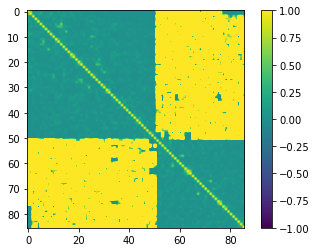

In [43]:
ff = np.abs(fish_both)
corr_fish = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
plt.imshow(corr_fish,vmax=1,vmin=-1);
plt.colorbar();

In [47]:
tspec.generate_sims(10,Cl_th+Nl_th)

Using 10 Monte Carlo simulations


In [48]:
t_unwindowed_even = tspec.Tl_numerator(data,parity='both',verb=True)

Computing t0 term
Computing t0 term
Computing H^+- maps
Computing A maps
Computing A maps for cross-spectra
Assembling parity-even trispectrum numerator
Assembling parity-odd trispectrum numerator


### cross-terms don't seem to work yet??
### check there's the same symmetry there!

### could check just with a constant window that there's no effects?

## can we use transpose symmetry to drop half the Fisher matrix bins? force index2>index1?

## switch to just computing Im part of trispectrum?
## also helps in Fisher?

In [3]:
t_even, t_odd = tspec.Tl_ideal(data,parity='both',verb=True)

Computing ideal Fisher matrix
Using 51 even-parity trispectrum bins
Using 35 odd-parity trispectrum bins
Computing bin 5 of 51
Computing bin 10 of 51
Computing bin 15 of 51
Computing bin 20 of 51
Computing bin 25 of 51
Computing bin 30 of 51
Computing bin 35 of 51
Computing bin 40 of 51
Computing bin 45 of 51
Computing bin 50 of 51
Computing numerator
Computing H^+- maps
Computing A maps
Assembling parity-even trispectrum numerator
Assembling parity-odd trispectrum numerator


In [4]:
t_even2 = tspec.Tl_ideal(data,parity='even',verb=True)

Using precomputed Fisher matrix
Computing numerator
Computing H^+- maps
Computing A maps
Assembling parity-even trispectrum numerator
